# Task 1: Data Preprocessing and Analysis
Overview

We're building a portfolio optimization system for GMF Investments using three key assets:

TSLA: High-growth, high-risk stock

BND: Stable bond ETF for income

SPY: Diversified market exposure

This analysis will help us understand each asset's behavior and prepare data for forecasting models.



# Step 1: Data Collection

Why we need this data?

We need historical price data to understand how each asset has performed over time. This data will form the foundation for our forecasting models and portfolio optimization

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Define our assets and time period
tickers = ['TSLA', 'BND', 'SPY']
start_date = '2015-07-01'
end_date = '2025-07-31'

print("Fetching data for our portfolio assets...")
print(f"Assets: {tickers}")
print(f"Period: {start_date} to {end_date}")

Fetching data for our portfolio assets...
Assets: ['TSLA', 'BND', 'SPY']
Period: 2015-07-01 to 2025-07-31


# Step 2: Data Cleaning and Understanding

Financial data can have missing values, wrong data types, or inconsistencies. Clean data ensures our analysis and models work correctly

In [4]:
# Download data for all tickers
data = {}
for ticker in tickers:
    print(f"Downloading {ticker} data...")
    data[ticker] = yf.download(ticker, start=start_date, end=end_date)
    print(f"✓ {ticker}: {len(data[ticker])} trading days")

print("\nData collection complete!")

[*********************100%***********************]  1 of 1 completed


✓ TSLA: 2535 trading days


[*********************100%***********************]  1 of 1 completed


✓ BND: 2535 trading days


[*********************100%***********************]  1 of 1 completed

✓ SPY: 2535 trading days

Data collection complete!


In [5]:
# Check basic information about our datasets
print("=== DATA OVERVIEW ===")
for ticker in tickers:
    df = data[ticker]
    print(f"\n{ticker} Dataset:")
    print(f"Shape: {df.shape}")
    print(f"Date range: {df.index.min()} to {df.index.max()}")
    print(f"Columns: {list(df.columns)}")

=== DATA OVERVIEW ===

TSLA Dataset:
Shape: (2535, 5)
Date range: 2015-07-01 00:00:00 to 2025-07-30 00:00:00
Columns: [('Close', 'TSLA'), ('High', 'TSLA'), ('Low', 'TSLA'), ('Open', 'TSLA'), ('Volume', 'TSLA')]

BND Dataset:
Shape: (2535, 5)
Date range: 2015-07-01 00:00:00 to 2025-07-30 00:00:00
Columns: [('Close', 'BND'), ('High', 'BND'), ('Low', 'BND'), ('Open', 'BND'), ('Volume', 'BND')]

SPY Dataset:
Shape: (2535, 5)
Date range: 2015-07-01 00:00:00 to 2025-07-30 00:00:00
Columns: [('Close', 'SPY'), ('High', 'SPY'), ('Low', 'SPY'), ('Open', 'SPY'), ('Volume', 'SPY')]


Check for Missing Value

In [7]:
print("\n=== MISSING VALUES CHECK ===")
for ticker in tickers:
    df = data[ticker]
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"\n{ticker} missing values:")
        print(missing[missing > 0])
    else:
        print(f"✓ {ticker}: No missing values")


=== MISSING VALUES CHECK ===
✓ TSLA: No missing values
✓ BND: No missing values
✓ SPY: No missing values


In [9]:
# Clean the data
cleaned_data = {}
for ticker in tickers:
    df = data[ticker].copy()
    
    # Forward fill any missing values (use previous day's price)
    df = df.fillna(method='ffill')
    
    # If still missing values at the beginning, use backward fill
    df = df.fillna(method='bfill')
    
    cleaned_data[ticker] = df
    print(f"✓ {ticker} data cleaned")

print("Data cleaning complete!")

✓ TSLA data cleaned
✓ BND data cleaned
✓ SPY data cleaned
Data cleaning complete!


# Step 3: Basic Statistical Analysis

Why we need statistics

Understanding basic statistics helps us know what's normal vs abnormal for each asset, which is crucial for risk assessment.

In [12]:
print("=== BASIC STATISTICS ===")
for ticker in tickers:
    df = cleaned_data[ticker]
    close_price = df['Close']
    
    print(f"\n{ticker} - Close Price Statistics:")
    print(f"Mean: ${float(close_price.mean()):.2f}")
    print(f"Median: ${float(close_price.median()):.2f}")
    print(f"Std Dev: ${float(close_price.std()):.2f}")
    print(f"Min: ${float(close_price.min()):.2f}")
    print(f"Max: ${float(close_price.max()):.2f}")

=== BASIC STATISTICS ===

TSLA - Close Price Statistics:
Mean: $131.96
Median: $94.57
Std Dev: $120.91
Min: $9.58
Max: $479.86

BND - Close Price Statistics:
Mean: $68.47
Median: $67.60
Std Dev: $4.55
Min: $60.78
Max: $77.32

SPY - Close Price Statistics:
Mean: $334.19
Median: $305.26
Std Dev: $126.43
Min: $155.87
Max: $637.10


SUMMARY

TSLA is the most volatile and has the highest max price (consistent with a high-growth stock)

BND is stable with low standard deviation and tight price range (typical for bond ETFs)

SPY is somewhere in between, reflecting broad market exposure

# Step 4: Exploratory Data Analysis (EDA)

4.1 Price Trends Visualization

Price charts show us the overall direction and volatility patterns, helping us understand each asset's behavior over time

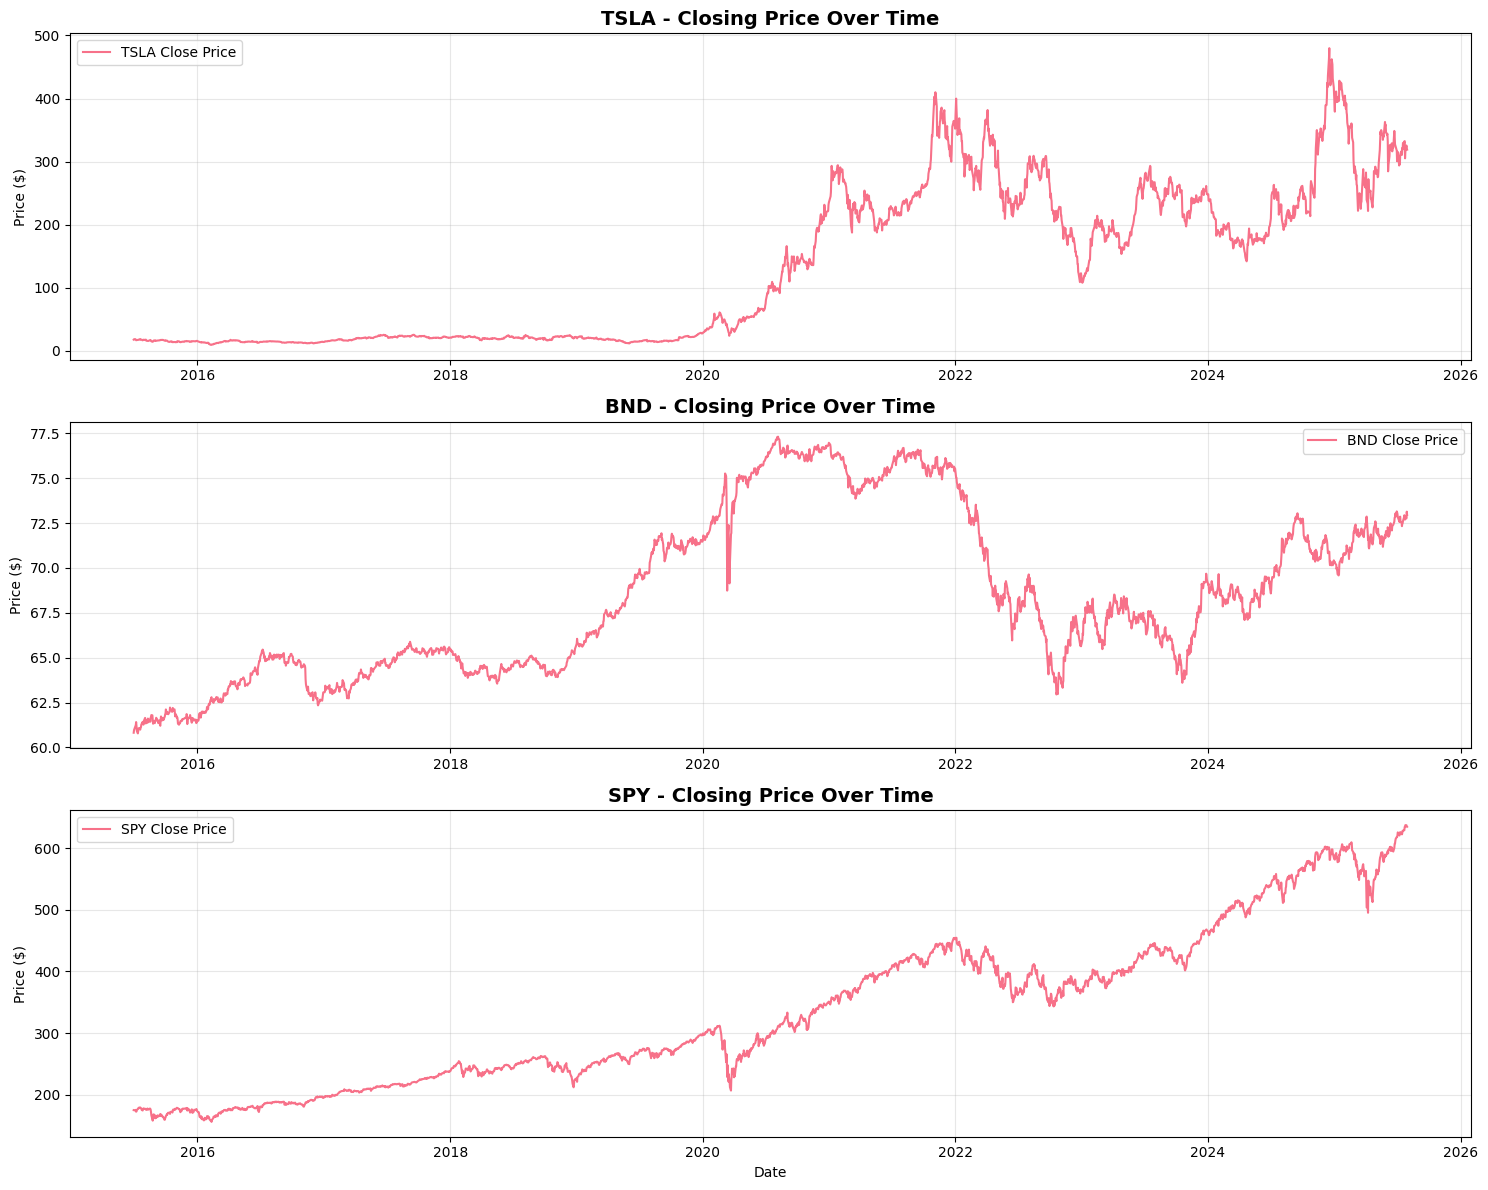

In [13]:
# Create a comprehensive price analysis
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

for i, ticker in enumerate(tickers):
    df = cleaned_data[ticker]
    
    # Plot closing prices
    axes[i].plot(df.index, df['Close'], linewidth=1.5, label=f'{ticker} Close Price')
    axes[i].set_title(f'{ticker} - Closing Price Over Time', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Price ($)')
    axes[i].grid(True, alpha=0.3)
    axes[i].legend()

plt.xlabel('Date')
plt.tight_layout()
plt.show()

4.2 Daily Returns Analysis

Daily returns show us how much an asset's value changes each day as a percentage. This is more useful than raw prices for comparing different assets.

In [19]:
# Calculate daily returns for each asset
returns_data = {}
print("=== CALCULATING DAILY RETURNS ===")

for ticker in tickers:
    df = cleaned_data[ticker]  # already a single ticker's DataFrame
    close_prices = df[('Close', ticker)]  # explicitly pick the Close column for that ticker
    
    daily_returns = close_prices.pct_change().dropna()
    returns_data[ticker] = daily_returns

    mean_return = float(daily_returns.mean())
    std_return = float(daily_returns.std())

    print(f"{ticker} daily returns:")
    print(f"  Mean: {mean_return:.4f} ({mean_return*252:.2%} annualized)")
    print(f"  Std Dev: {std_return:.4f} ({std_return*np.sqrt(252):.2%} annualized)")
    print(f"  Min: {daily_returns.min():.4f}")
    print(f"  Max: {daily_returns.max():.4f}")


=== CALCULATING DAILY RETURNS ===
TSLA daily returns:
  Mean: 0.0018 (46.07% annualized)
  Std Dev: 0.0373 (59.19% annualized)
  Min: -0.2106
  Max: 0.2269
BND daily returns:
  Mean: 0.0001 (1.96% annualized)
  Std Dev: 0.0035 (5.49% annualized)
  Min: -0.0544
  Max: 0.0422
SPY daily returns:
  Mean: 0.0006 (14.48% annualized)
  Std Dev: 0.0115 (18.24% annualized)
  Min: -0.1094
  Max: 0.1050


Visualize daily returns

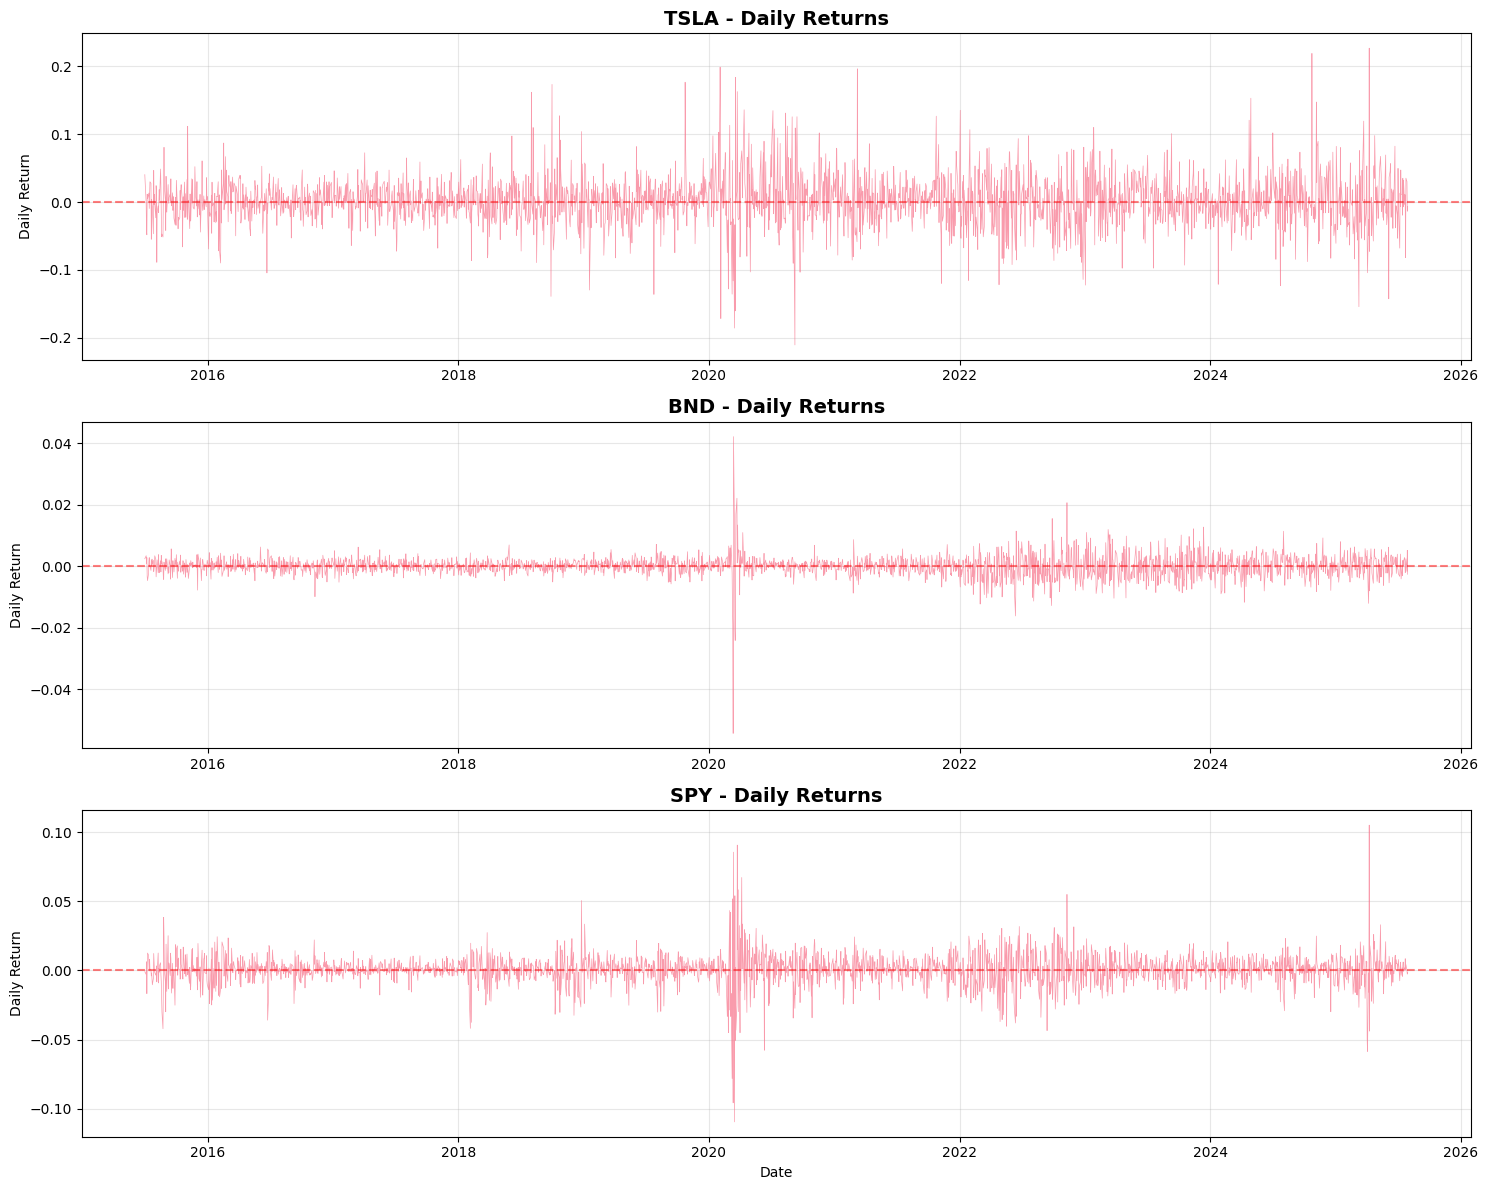

In [22]:
# Plot daily returns
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

for i, ticker in enumerate(tickers):
    returns = returns_data[ticker]
    
    axes[i].plot(returns.index, returns, alpha=0.7, linewidth=0.5)
    axes[i].set_title(f'{ticker} - Daily Returns', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Daily Return')
    axes[i].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[i].grid(True, alpha=0.3)

plt.xlabel('Date')
plt.tight_layout()
plt.show()

TSLA: High mean daily return (~0.18%) and very high volatility (~3.7%), reflecting its high-risk, high-reward nature.

BND: Very low mean return and volatility, typical for a bond ETF focusing on stability.

SPY: Moderate returns and volatility, typical of a broad market ETF.

4.3 Volatility Analysis

Volatility tells us how much an asset's price fluctuates. Higher volatility means higher risk but potentially higher returns. 

=== VOLATILITY ANALYSIS ===
TSLA average volatility: 55.30%
BND average volatility: 4.62%
SPY average volatility: 15.49%


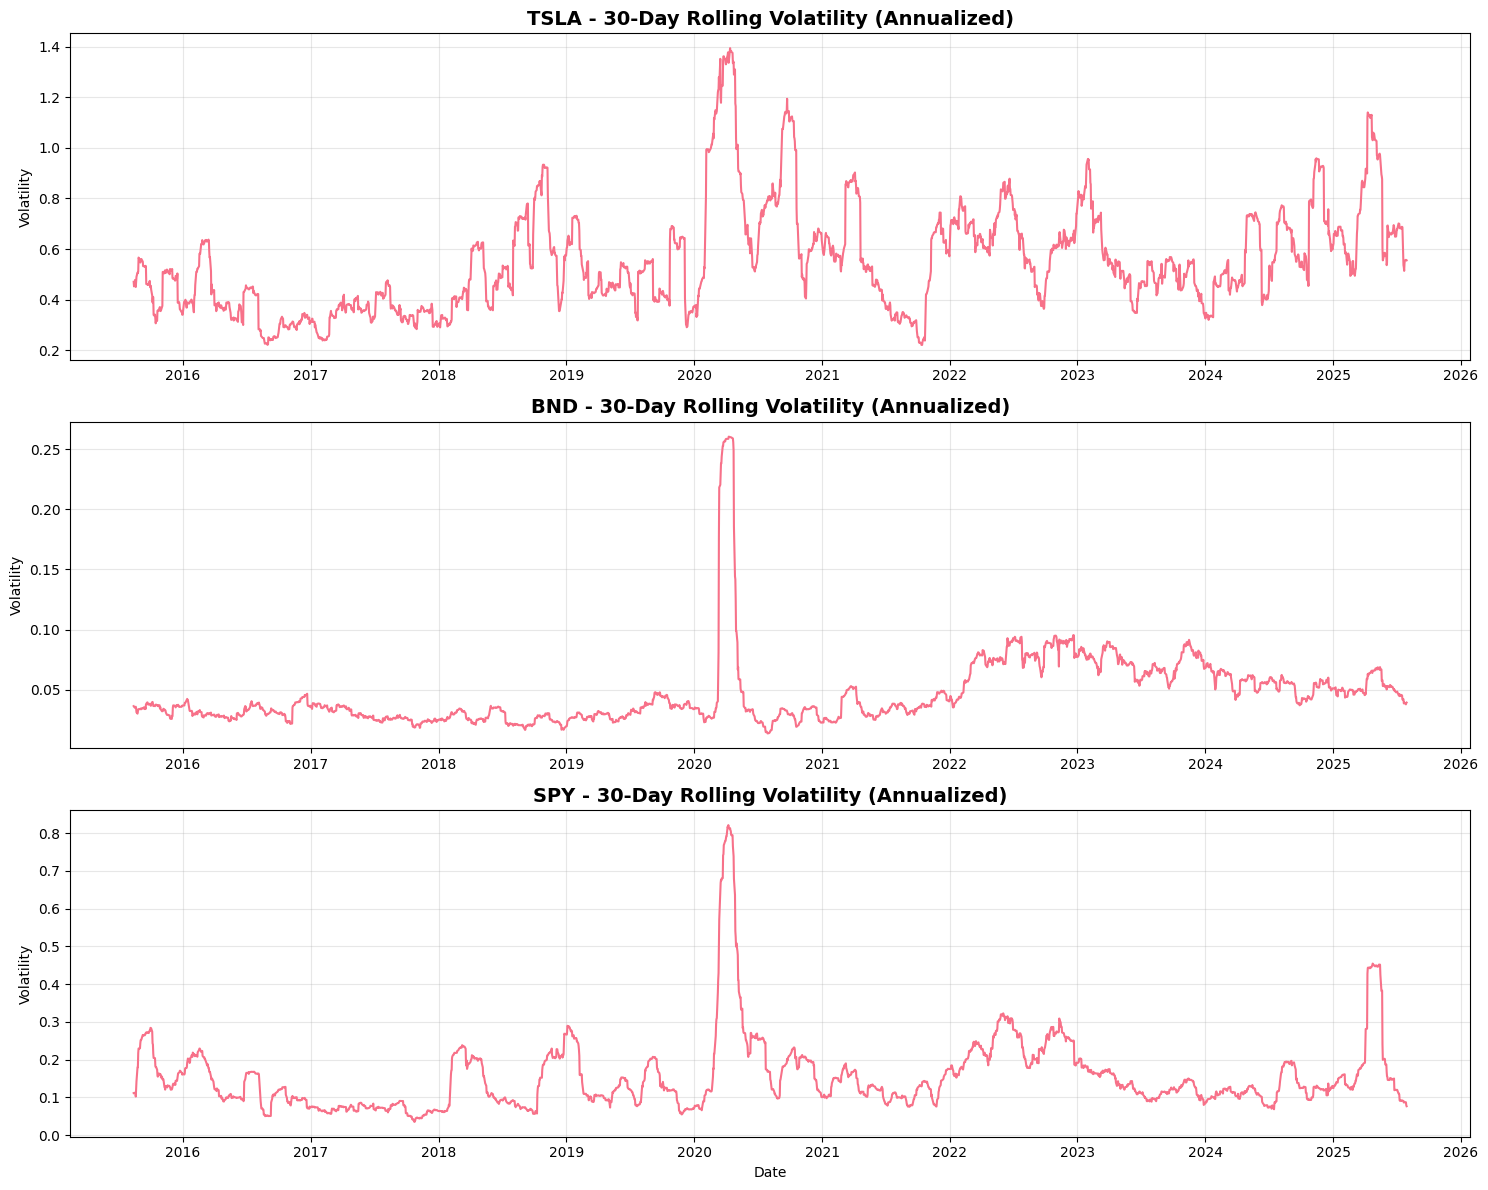

In [23]:
# Calculate rolling volatility (30-day rolling standard deviation)
print("=== VOLATILITY ANALYSIS ===")

fig, axes = plt.subplots(3, 1, figsize=(15, 12))

for i, ticker in enumerate(tickers):
    returns = returns_data[ticker]
    
    # Calculate 30-day rolling volatility
    rolling_vol = returns.rolling(window=30).std() * np.sqrt(252)  # Annualized
    
    axes[i].plot(rolling_vol.index, rolling_vol, linewidth=1.5)
    axes[i].set_title(f'{ticker} - 30-Day Rolling Volatility (Annualized)', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Volatility')
    axes[i].grid(True, alpha=0.3)
    
    print(f"{ticker} average volatility: {rolling_vol.mean():.2%}")

plt.xlabel('Date')
plt.tight_layout()
plt.show()

# Step 5: Outlier Detection

Extreme price movements can indicate important events (earnings, news, market crashes) that might affect our forecasting models.

In [24]:
print("=== OUTLIER DETECTION ===")

for ticker in tickers:
    returns = returns_data[ticker]
    
    # Define outliers as returns beyond 2 standard deviations
    mean_return = returns.mean()
    std_return = returns.std()
    
    # Find extreme positive and negative days
    extreme_positive = returns[returns > mean_return + 2*std_return]
    extreme_negative = returns[returns < mean_return - 2*std_return]
    
    print(f"\n{ticker} Outlier Analysis:")
    print(f"Extreme positive days: {len(extreme_positive)}")
    print(f"Extreme negative days: {len(extreme_negative)}")
    
    if len(extreme_positive) > 0:
        print(f"Best day: {extreme_positive.max():.2%} on {extreme_positive.idxmax().strftime('%Y-%m-%d')}")
    if len(extreme_negative) > 0:
        print(f"Worst day: {extreme_negative.min():.2%} on {extreme_negative.idxmin().strftime('%Y-%m-%d')}")

=== OUTLIER DETECTION ===

TSLA Outlier Analysis:
Extreme positive days: 72
Extreme negative days: 60
Best day: 22.69% on 2025-04-09
Worst day: -21.06% on 2020-09-08

BND Outlier Analysis:
Extreme positive days: 48
Extreme negative days: 48
Best day: 4.22% on 2020-03-13
Worst day: -5.44% on 2020-03-12

SPY Outlier Analysis:
Extreme positive days: 45
Extreme negative days: 72
Best day: 10.50% on 2025-04-09
Worst day: -10.94% on 2020-03-16


TSLA has the most extreme positive and negative days  72 and 60 respectively — highlighting its high volatility and risk.

BND shows balanced but far fewer extreme moves, consistent with a stable bond ETF.

SPY has more extreme negative days (72) than positive (45), reflecting market downturns impact more often or severely.

 best/worst day dates align with known market events, for example:

TSLA’s huge drop on 2020-09-08 and spike on 2025-04-09 

SPY’s worst day on 2020-03-16 lines up with the COVID crash

# Step 6: Stationarity Testing

Many forecasting models (like ARIMA) require stationary data - meaning the statistical properties don't change over time. This test tells us if we need to transform our data.

In [29]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries, title):
    """
    Perform Augmented Dickey-Fuller test for stationarity
    """
    print(f'\n=== {title} ===')
    
    # Perform ADF test
    result = adfuller(timeseries.dropna())
    
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    # Interpret results
    if result[1] <= 0.05:
        print("✓ Series is stationary (reject null hypothesis)")
    else:
        print("✗ Series is non-stationary (fail to reject null hypothesis)")
    
    return result[1] <= 0.05

print("=== STATIONARITY TESTING ===")

# Test stationarity for prices and returns
stationarity_results = {}

for ticker in tickers:
    print(f"\n{ticker} Analysis:")
    
    # Test prices (usually non-stationary)
    prices = cleaned_data[ticker]['Close']
    is_stationary_price = check_stationarity(prices, f"{ticker} Prices")
    
    # Test returns (usually stationary)
    returns = returns_data[ticker]
    is_stationary_returns = check_stationarity(returns, f"{ticker} Returns")
    
    stationarity_results[ticker] = {
        'prices_stationary': is_stationary_price,
        'returns_stationary': is_stationary_returns
    }

=== STATIONARITY TESTING ===

TSLA Analysis:

=== TSLA Prices ===
ADF Statistic: -1.418872
p-value: 0.573196
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
✗ Series is non-stationary (fail to reject null hypothesis)

=== TSLA Returns ===
ADF Statistic: -34.681090
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
✓ Series is stationary (reject null hypothesis)

BND Analysis:

=== BND Prices ===
ADF Statistic: -1.536251
p-value: 0.515508
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
✗ Series is non-stationary (fail to reject null hypothesis)

=== BND Returns ===
ADF Statistic: -9.889775
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
✓ Series is stationary (reject null hypothesis)

SPY Analysis:

=== SPY Prices ===
ADF Statistic: 0.690812
p-value: 0.989653
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
✗ Series is non-stationary (fail to reject null hypothesis)

=== SPY Returns ===
ADF Statistic: -16.264377
p-value: 0.00

Price series for TSLA, BND, and SPY are all non-stationary, meaning their statistical properties like mean and variance change over time. This is expected for raw price data.

Returns for all three assets are stationary, which is typical because returns usually fluctuate around a constant mean and variance.

Step 7: Risk Metrics Calculation

Risk metrics help us understand the potential downside of each investment and compare risk-adjusted returns.

In [31]:
print("=== RISK METRICS CALCULATION ===")

risk_metrics = {}

for ticker in tickers:
    returns = returns_data[ticker]
    
    # Calculate Value at Risk (VaR) at 95% confidence level
    var_95 = np.percentile(returns, 5)  # 5th percentile
    
    # Calculate Sharpe Ratio (assuming risk-free rate of 2%)
    risk_free_rate = 0.02 / 252  # Daily risk-free rate
    excess_returns = returns - risk_free_rate
    sharpe_ratio = excess_returns.mean() / returns.std() * np.sqrt(252)
    
    # Maximum drawdown calculation
    prices = cleaned_data[ticker]['Close']
    cumulative_returns = (1 + returns).cumprod()
    rolling_max = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    
    risk_metrics[ticker] = {
        'var_95': var_95,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'annual_volatility': returns.std() * np.sqrt(252)
    }
    
    print(f"\n{ticker} Risk Metrics:")
    print(f"  VaR (95%): {var_95:.2%} (worst 5% of days)")
    print(f"  Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"  Max Drawdown: {max_drawdown:.2%}")
    print(f"  Annual Volatility: {returns.std() * np.sqrt(252):.2%}")

=== RISK METRICS CALCULATION ===

TSLA Risk Metrics:
  VaR (95%): -5.47% (worst 5% of days)
  Sharpe Ratio: 0.74
  Max Drawdown: -73.63%
  Annual Volatility: 59.19%

BND Risk Metrics:
  VaR (95%): -0.49% (worst 5% of days)
  Sharpe Ratio: -0.01
  Max Drawdown: -18.58%
  Annual Volatility: 5.49%

SPY Risk Metrics:
  VaR (95%): -1.72% (worst 5% of days)
  Sharpe Ratio: 0.68
  Max Drawdown: -33.72%
  Annual Volatility: 18.24%


Step 8: Summary and Key Insights

In [32]:
print("=== PORTFOLIO ASSET SUMMARY ===")

# Create a summary comparison
summary_df = pd.DataFrame({
    'Annual Return': [returns_data[ticker].mean() * 252 for ticker in tickers],
    'Annual Volatility': [risk_metrics[ticker]['annual_volatility'] for ticker in tickers],
    'Sharpe Ratio': [risk_metrics[ticker]['sharpe_ratio'] for ticker in tickers],
    'Max Drawdown': [risk_metrics[ticker]['max_drawdown'] for ticker in tickers],
    'VaR (95%)': [risk_metrics[ticker]['var_95'] for ticker in tickers]
}, index=tickers)

print(summary_df.round(4))

# Key insights
print("\n=== KEY INSIGHTS ===")
print("1. Asset Characteristics:")
for ticker in tickers:
    if ticker == 'TSLA':
        print(f"   • {ticker}: High-growth stock with high volatility and potential for large gains/losses")
    elif ticker == 'BND':
        print(f"   • {ticker}: Stable bond ETF with low volatility, providing steady income")
    elif ticker == 'SPY':
        print(f"   • {ticker}: Market index with moderate risk, good for diversification")

print("\n2. Stationarity Results:")
for ticker in tickers:
    price_stat = stationarity_results[ticker]['prices_stationary']
    return_stat = stationarity_results[ticker]['returns_stationary']
    print(f"   • {ticker}: Prices {'stationary' if price_stat else 'non-stationary'}, Returns {'stationary' if return_stat else 'non-stationary'}")

print("\n3. Data Quality:")
print("   • All datasets are clean with no missing values")
print("   • Data covers the full requested period (2015-2025)")
print("   • Ready for time series modeling")

print("\nNext Steps:")
print("• Use this cleaned data for ARIMA/LSTM forecasting models")
print("• Consider using returns (stationary) rather than prices for modeling")
print("• Factor in the risk characteristics when optimizing portfolio weights")

=== PORTFOLIO ASSET SUMMARY ===
      Annual Return  Annual Volatility  Sharpe Ratio  Max Drawdown  VaR (95%)
TSLA         0.4607             0.5919        0.7446       -0.7363    -0.0547
BND          0.0196             0.0549       -0.0073       -0.1858    -0.0049
SPY          0.1448             0.1824        0.6844       -0.3372    -0.0172

=== KEY INSIGHTS ===
1. Asset Characteristics:
   • TSLA: High-growth stock with high volatility and potential for large gains/losses
   • BND: Stable bond ETF with low volatility, providing steady income
   • SPY: Market index with moderate risk, good for diversification

2. Stationarity Results:
   • TSLA: Prices non-stationary, Returns stationary
   • BND: Prices non-stationary, Returns stationary
   • SPY: Prices non-stationary, Returns stationary

3. Data Quality:
   • All datasets are clean with no missing values
   • Data covers the full requested period (2015-2025)
   • Ready for time series modeling

Next Steps:
• Use this cleaned data fo

In [ ]:
# Save processed data 
print("=== SAVING PROCESSED DATA ===")

# Combine all data into organized dictionaries
processed_data = {
    'prices': {ticker: cleaned_data[ticker] for ticker in tickers},
    'returns': returns_data,
    'risk_metrics': risk_metrics,
    'stationarity_results': stationarity_results
}

# You can save this data to files if needed
import pickle

with open('processed_portfolio_data.pkl', 'wb') as f:
    pickle.dump(processed_data, f)

print("✓ Data saved for use in Tasks 2-5")
print("✓ Task 1 Complete!")

=== SAVING PROCESSED DATA ===
✓ Data saved for use in Tasks 2-5
✓ Task 1 Complete!
